# Mantenimiento Predictivo de Turbinas

Durante la vida útil de las turbinas, estas sufren desgaste, que impacta directamente en su confiabilidad y performance.
Esta notebook es para crear un modelo reutilizable, que en este caso es para predecir la vida util restante (RUL: remaining useful life) de turbinas, basado en data sobre el ciclo de vida completo de las mismas para planificar mejor su mantenimiento.

<img src='_src/turbofan-operation-lbp.png'>

In [71]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost

from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# venv/Scripts/Activate.ps1

#### Definimos nombres de variables

In [72]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i+1}' for i in range(0, 21)]
col_names = index_names + setting_names + sensor_names

#### Importamos la data de entrenamiento y de validación.

In [73]:
dftrain = pd.read_csv('_data/train_FD002.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('_data/test_FD002.txt',sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv('_data/RUL_FD002.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
dfvalid.shape

(33991, 26)

In [74]:
train = dftrain.copy()
valid = dfvalid.copy()

train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,...,314.05,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,...,371.22,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,...,163.74,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,...,164.37,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729


In [75]:
print('Forma del set de entrenamiento: ', train.shape)
print('Forma del set de validación: ',valid.shape)
print('Porcentaje del set de validación: ',len(valid)/(len(valid)+len(train)))

Forma del set de entrenamiento:  (53759, 26)
Forma del set de validación:  (33991, 26)
Porcentaje del set de validación:  0.38736182336182334


In [76]:
train.isna().sum()

unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64

Cantidad de ciclos de cada unidad.

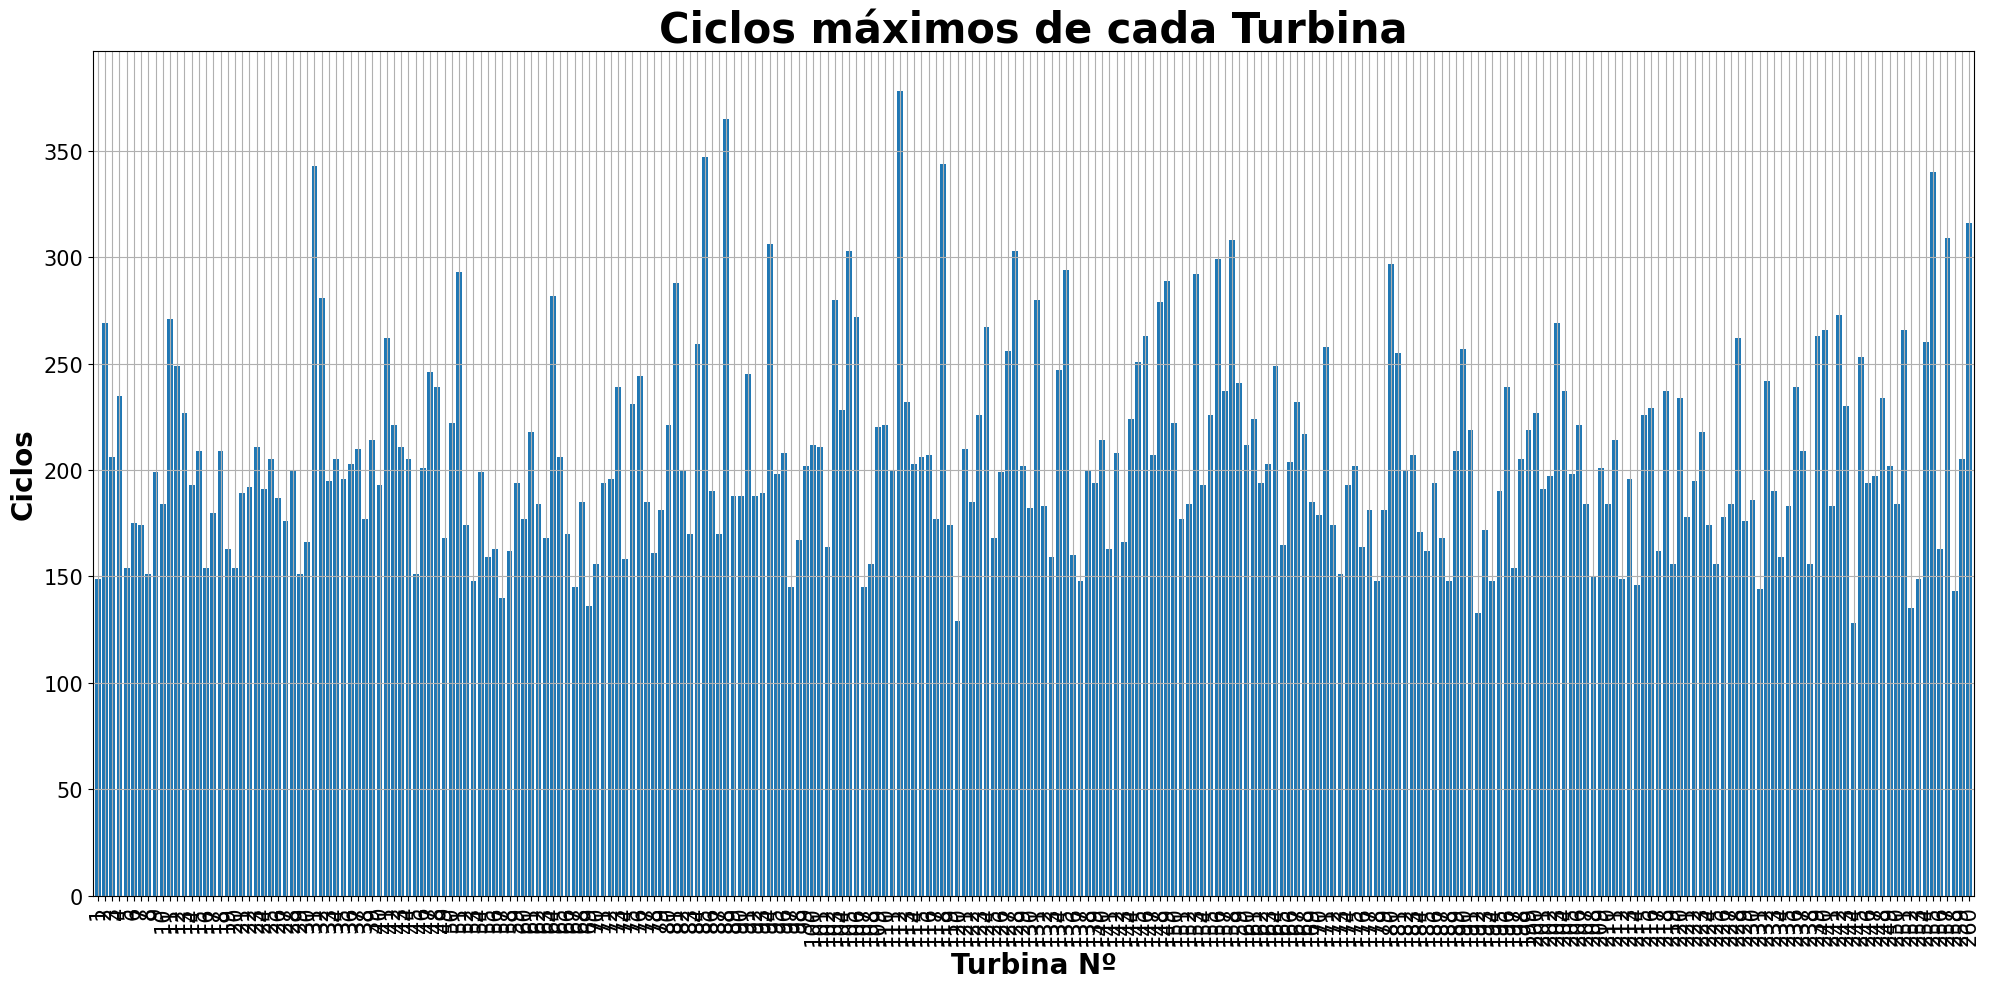

In [77]:
ciclos_maximos = train[index_names].groupby('unit_number').max()
plt.figure(figsize=(20,10))
ax = ciclos_maximos['time_cycles'].plot(kind='bar', width=0.8, stacked=True, align='center')
plt.title('Ciclos máximos de cada Turbina',fontweight='bold',size=30)
plt.xlabel('Turbina Nº',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('Ciclos',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 9.444444444444459, 'Ciclos máximos')

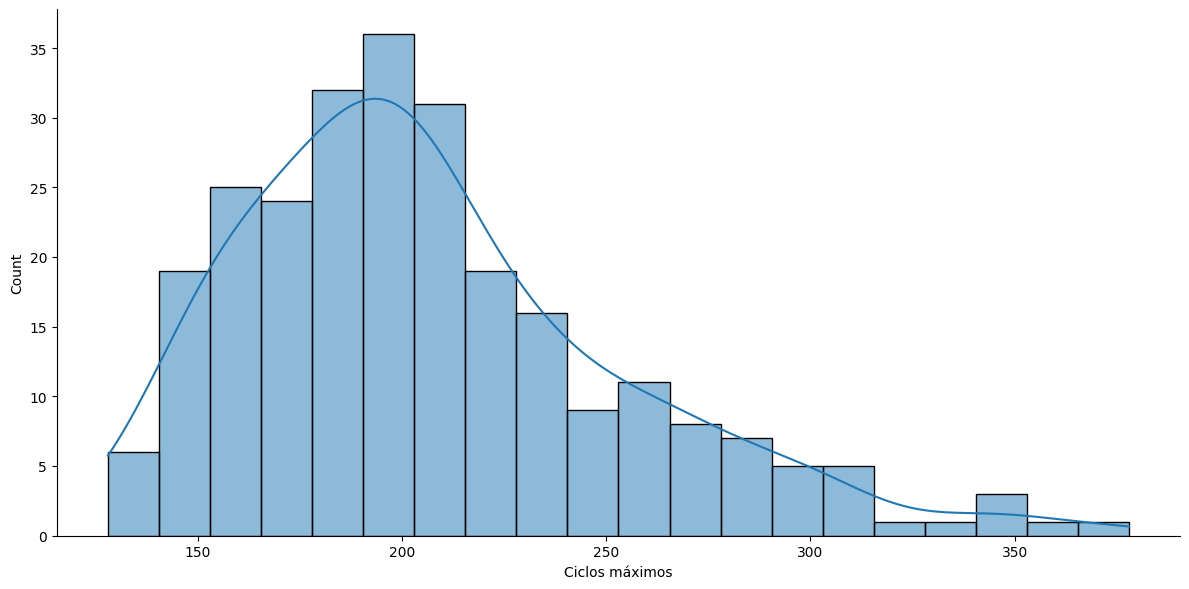

In [78]:
sns.displot(ciclos_maximos['time_cycles'], kde=True, bins=20, height=6, aspect=2)
plt.xlabel('Ciclos máximos')

---

### Añadimos la columna RUL a la data

Indica los ciclos restantes de cada unidad antes de que falle.

In [83]:
def add_RUL_and_risk(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number', right_index=True)
    mask = merged[merged["max_time_cycle"] == merged["time_cycles"]]
    index = list(mask.index)
    merged["risk"] = ""
    for n in index:
        merged.iloc[n-39 : n+1]["risk"].replace("", "M", inplace=True)
        merged.iloc[n-19 : n+1]["risk"].replace("M", "H", inplace=True)
    merged.replace("", "L", inplace=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [84]:
train = add_RUL_and_risk(train)

In [85]:
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,risk,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,L,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,L,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,L,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,L,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,L,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,...,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189,H,4
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,...,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454,H,3
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,...,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503,H,2
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,...,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729,H,1


In [62]:
max_time_cycles = train_grouped_by_unit['time_cycles'].max()
max_time_cycles

unit_number
1      149
2      269
3      206
4      235
5      154
      ... 
256    163
257    309
258    143
259    205
260    316
Name: time_cycles, Length: 260, dtype: int64

In [63]:
merged = train.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
merged

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,max_time_cycle
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148,149
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147,149
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146,149
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145,149
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144,149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,...,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189,4,316
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,...,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454,3,316
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,...,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503,2,316
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,...,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729,1,316


In [64]:
mask = merged[merged["max_time_cycle"] == merged["time_cycles"]]
mask.index

Index([  148,   417,   623,   858,  1012,  1187,  1361,  1512,  1711,  1895,
       ...
       51738, 51873, 52022, 52282, 52622, 52785, 53094, 53237, 53442, 53758],
      dtype='int64', length=260)

In [65]:
merged.iloc[mask.index]

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,max_time_cycle
148,1,149,42.0017,0.8414,100.0,445.00,550.49,1366.01,1149.81,3.91,...,8066.19,9.4765,0.02,332,2212,100.0,10.45,6.2285,0,149
417,2,269,42.0047,0.8411,100.0,445.00,550.11,1368.75,1146.65,3.91,...,8110.26,9.4315,0.02,334,2212,100.0,10.56,6.2615,0,269
623,3,206,42.0073,0.8400,100.0,445.00,550.80,1356.97,1144.89,3.91,...,8082.25,9.4962,0.02,333,2212,100.0,10.46,6.3349,0,206
858,4,235,0.0030,0.0007,100.0,518.67,643.68,1605.86,1428.21,14.62,...,8215.14,8.5784,0.03,397,2388,100.0,38.47,22.9717,0,235
1012,5,154,42.0049,0.8408,100.0,445.00,550.53,1364.82,1146.87,3.91,...,8151.36,9.4339,0.02,333,2212,100.0,10.74,6.3906,0,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52785,256,163,0.0019,0.0003,100.0,518.67,643.15,1597.21,1425.84,14.62,...,8128.22,8.5586,0.03,396,2388,100.0,38.62,23.0771,0,163
53094,257,309,42.0077,0.8411,100.0,445.00,550.84,1369.00,1146.53,3.91,...,8171.37,9.4156,0.02,336,2212,100.0,10.47,6.3085,0,309
53237,258,143,9.9984,0.2500,100.0,489.05,606.05,1513.93,1326.79,10.52,...,8124.16,8.7392,0.03,372,2319,100.0,28.32,16.9473,0,143
53442,259,205,41.9989,0.8405,100.0,445.00,550.60,1366.52,1149.97,3.91,...,8075.91,9.4882,0.02,333,2212,100.0,10.30,6.2778,0,205


In [66]:
merged.iloc[148]["s_1"]

445.0

In [67]:
train["risk"] = ""
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,risk
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148,
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147,
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146,
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145,
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,...,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189,4,
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,...,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454,3,
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,...,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503,2,
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,...,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729,1,


In [68]:
indice = list(mask.index)
indice


[148,
 417,
 623,
 858,
 1012,
 1187,
 1361,
 1512,
 1711,
 1895,
 2166,
 2415,
 2642,
 2835,
 3044,
 3198,
 3378,
 3587,
 3750,
 3904,
 4093,
 4285,
 4496,
 4687,
 4892,
 5079,
 5255,
 5455,
 5606,
 5772,
 6115,
 6396,
 6591,
 6796,
 6992,
 7195,
 7405,
 7582,
 7796,
 7989,
 8251,
 8472,
 8683,
 8888,
 9039,
 9240,
 9486,
 9725,
 9893,
 10115,
 10408,
 10582,
 10730,
 10929,
 11088,
 11251,
 11391,
 11553,
 11747,
 11924,
 12142,
 12326,
 12494,
 12776,
 12982,
 13152,
 13297,
 13482,
 13618,
 13774,
 13968,
 14164,
 14403,
 14561,
 14792,
 15036,
 15221,
 15382,
 15563,
 15784,
 16072,
 16272,
 16442,
 16701,
 17048,
 17238,
 17408,
 17773,
 17961,
 18149,
 18394,
 18582,
 18771,
 19077,
 19275,
 19483,
 19628,
 19795,
 19997,
 20209,
 20420,
 20584,
 20864,
 21092,
 21395,
 21667,
 21812,
 21968,
 22188,
 22409,
 22609,
 22987,
 23219,
 23422,
 23628,
 23835,
 24012,
 24356,
 24530,
 24659,
 24869,
 25054,
 25280,
 25547,
 25715,
 25914,
 26170,
 26473,
 26675,
 26857,
 27137,
 2732

In [69]:
for n in indice:
    train.iloc[n-39 : n+1]["risk"].replace("", "moderated", inplace=True)
    train.iloc[n-19 : n+1]["risk"].replace("moderated", "high", inplace=True)

In [70]:
train.iloc[100:150]

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,risk
100,1,101,42.0021,0.8400,100.0,445.00,549.99,1349.48,1135.38,3.91,...,8066.89,9.3842,0.02,330,2212,100.00,10.50,6.4038,48,
101,1,102,35.0063,0.8400,100.0,449.44,555.90,1376.66,1139.31,5.48,...,8059.02,9.3595,0.02,334,2223,100.00,14.86,8.8523,47,
102,1,103,20.0057,0.7010,100.0,491.19,607.32,1495.89,1258.36,9.35,...,8045.91,9.2488,0.03,366,2324,100.00,24.22,14.7405,46,
103,1,104,35.0078,0.8400,100.0,449.44,556.29,1362.75,1129.45,5.48,...,8056.86,9.3655,0.02,335,2223,100.00,14.81,8.9265,45,
104,1,105,20.0052,0.7000,100.0,491.19,607.04,1487.94,1261.08,9.35,...,8045.38,9.2580,0.03,364,2324,100.00,24.37,14.5177,44,
105,1,106,0.0008,0.0019,100.0,518.67,643.12,1590.38,1414.45,14.62,...,8122.68,8.4556,0.03,394,2388,100.00,38.68,23.2542,43,
106,1,107,35.0037,0.8411,100.0,449.44,555.85,1365.70,1139.21,5.48,...,8064.94,9.3838,0.02,337,2223,100.00,14.85,8.9967,42,
107,1,108,41.9998,0.8414,100.0,445.00,550.09,1362.34,1133.92,3.91,...,8066.37,9.3829,0.02,331,2212,100.00,10.42,6.3999,41,
108,1,109,41.9991,0.8419,100.0,445.00,549.88,1360.26,1137.95,3.91,...,8063.48,9.3712,0.02,332,2212,100.00,10.47,6.3742,40,
109,1,110,20.0074,0.7019,100.0,491.19,607.79,1489.60,1267.13,9.35,...,8049.06,9.2481,0.03,368,2324,100.00,24.30,14.6406,39,moderated


In [30]:
index_high_arr = index_arr - 20
index_high_arr

array([  128,   397,   603,   838,   992,  1167,  1341,  1492,  1691,
        1875,  2146,  2395,  2622,  2815,  3024,  3178,  3358,  3567,
        3730,  3884,  4073,  4265,  4476,  4667,  4872,  5059,  5235,
        5435,  5586,  5752,  6095,  6376,  6571,  6776,  6972,  7175,
        7385,  7562,  7776,  7969,  8231,  8452,  8663,  8868,  9019,
        9220,  9466,  9705,  9873, 10095, 10388, 10562, 10710, 10909,
       11068, 11231, 11371, 11533, 11727, 11904, 12122, 12306, 12474,
       12756, 12962, 13132, 13277, 13462, 13598, 13754, 13948, 14144,
       14383, 14541, 14772, 15016, 15201, 15362, 15543, 15764, 16052,
       16252, 16422, 16681, 17028, 17218, 17388, 17753, 17941, 18129,
       18374, 18562, 18751, 19057, 19255, 19463, 19608, 19775, 19977,
       20189, 20400, 20564, 20844, 21072, 21375, 21647, 21792, 21948,
       22168, 22389, 22589, 22967, 23199, 23402, 23608, 23815, 23992,
       24336, 24510, 24639, 24849, 25034, 25260, 25527, 25695, 25894,
       26150, 26453,

In [31]:
index_low_arr = index_arr - 40
index_low_arr

array([  108,   377,   583,   818,   972,  1147,  1321,  1472,  1671,
        1855,  2126,  2375,  2602,  2795,  3004,  3158,  3338,  3547,
        3710,  3864,  4053,  4245,  4456,  4647,  4852,  5039,  5215,
        5415,  5566,  5732,  6075,  6356,  6551,  6756,  6952,  7155,
        7365,  7542,  7756,  7949,  8211,  8432,  8643,  8848,  8999,
        9200,  9446,  9685,  9853, 10075, 10368, 10542, 10690, 10889,
       11048, 11211, 11351, 11513, 11707, 11884, 12102, 12286, 12454,
       12736, 12942, 13112, 13257, 13442, 13578, 13734, 13928, 14124,
       14363, 14521, 14752, 14996, 15181, 15342, 15523, 15744, 16032,
       16232, 16402, 16661, 17008, 17198, 17368, 17733, 17921, 18109,
       18354, 18542, 18731, 19037, 19235, 19443, 19588, 19755, 19957,
       20169, 20380, 20544, 20824, 21052, 21355, 21627, 21772, 21928,
       22148, 22369, 22569, 22947, 23179, 23382, 23588, 23795, 23972,
       24316, 24490, 24619, 24829, 25014, 25240, 25507, 25675, 25874,
       26130, 26433,